<a href="https://colab.research.google.com/github/xychong/miniproject/blob/main/Data_Augmentation_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive/MyDrive/Data/train"
train_path_cat = "/content/drive/MyDrive/Data/train/cat"
train_path_dog = "/content/drive/MyDrive/Data/train/dog"

val_path = "/content/drive/MyDrive/Data/val"
val_path_cat = "/content/drive/MyDrive/Data/val/cat"
val_path_dog = "/content/drive/MyDrive/Data/val/dog"

test_path = "/content/drive/MyDrive/Data/test/"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
#train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(150,150),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

val_dataset = val_datagen.flow_from_directory(val_path,
                                              target_size=(150,150),
                                              batch_size = 32,
                                              class_mode = 'binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(150, 150, 3))
print(vgg_base.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [7]:
model = keras.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer 
        keras.layers.Flatten(),
        #keras.layers.Dropout(0.50),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.20),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.10),         
        keras.layers.Dense(1, activation='sigmoid')    
    ])

# Unfreeze the base model
vgg_base.trainable = True

# Observe how many layers are in the base model
# 19
print("Number of layers in the base model: ", len(vgg_base.layers))

# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all layers before 'fine_tune_at' layer
for layer in vgg_base.layers[:fine_tune_at]:
  layer.trainable = False

for layer in vgg_base.layers:
  print(layer, layer.trainable)

Number of layers in the base model:  19
<keras.engine.input_layer.InputLayer object at 0x7fcb36ce9450> False
<keras.layers.convolutional.Conv2D object at 0x7fcb364eeb50> False
<keras.layers.convolutional.Conv2D object at 0x7fcb344a3dd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcb35c55f50> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b76950> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b7bc90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcb35b7d810> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b80f10> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b8b650> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b80b90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcb35b16150> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b1a910> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b1ded0> False
<keras.layers.convolutional.Conv2D object at 0x7fcb35b132d0> False
<keras.layers.poolin

In [8]:
# Adjust the learning rate of Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt ,loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [10]:
train_steps = train_dataset.n // 32
val_steps = val_dataset.n // 32

print(train_steps)
print(val_steps)

100
25


In [11]:
training = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10, validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 1449s 14s/step - loss: 0.4066 - accuracy: 0.7997 - val_loss: 0.2940 - val_accuracy: 0.8825
Epoch 2/10
100/100 [==============================] - 828s 8s/step - loss: 0.2810 - accuracy: 0.8800 - val_loss: 0.1947 - val_accuracy: 0.9187
Epoch 3/10
100/100 [==============================] - 846s 8s/step - loss: 0.2403 - accuracy: 0.8969 - val_loss: 0.1798 - val_accuracy: 0.9237
Epoch 4/10
100/100 [==============================] - 845s 8s/step - loss: 0.2251 - accuracy: 0.9025 - val_loss: 0.2284 - val_accuracy: 0.9112
Epoch 5/10
100/100 [==============================] - 828s 8s/step - loss: 0.1957 - accuracy: 0.9228 - val_loss: 0.1567 - val_accuracy: 0.9337
Epoch 6/10
100/100 [==============================] - 841s 8s/step - loss: 0.1791 - accuracy: 0.9278 - val_loss: 0.1683 - val_accuracy: 0.9187
Epoch 7/10
100/100 [==============================] - 838s 8s/step - loss: 0.1727 - accuracy: 0.9281 - val_loss: 0.1765 - val_accuracy: 0.92

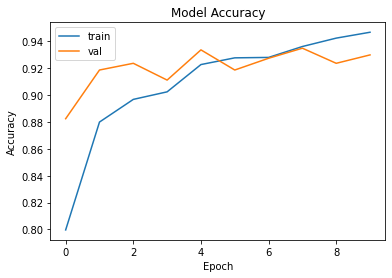

In [12]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

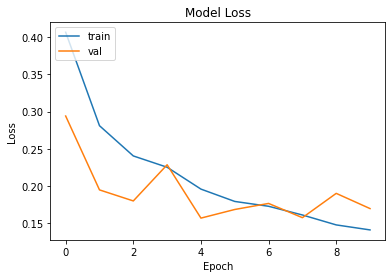

In [13]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
submission = pd.DataFrame(columns=['id','label'])
submission

,id,label


In [15]:
test_label = []
count = 0
for filename in os.listdir(test_path):
  first_word = filename.split('.')[0]
  img = image.load_img(test_path + filename, target_size = (150,150)) # load and resize image as 150x150
  Y = image.img_to_array(img) # convert image into a numpy array 
  X = np.expand_dims(Y,axis=0) # expand the dimension of that array
  val = model.predict(X)
  test_label.append(int(val))
  submission = submission.append({'id': int(first_word),'label': int(val)}, ignore_index=True)
  count += 1

print(test_label)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

In [16]:
submission
submission.to_csv('/content/drive/MyDrive/Data/submission10_aug.csv')  

In [17]:
sorted_submission = submission.sort_values('id')
sorted_submission
sorted_submission.to_csv('/content/drive/MyDrive/Data/sorted_submission10_aug.csv')  

In [18]:
sorted_submission

,id,label
466,1,1
431,2,1
459,3,1
345,4,1
376,5,1
...,...,...
315,496,1
337,497,1
164,498,0
151,499,1
